In [1]:
import polars as pl
import os
from pathlib import Path
import pandas as pd
import hvplot.polars
import datetime
import matplotlib.pyplot as plt
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay



sso_data = Path.cwd().parent / "Data/Option_data/SSO_complete.csv"
parquet_file = (Path.cwd().parent / "Data/Option_data/SSO_complete")

data_path = Path.cwd().parent / "Data"

#Restrictions
timeperiod = [datetime.datetime(2018, 12, 30), datetime.datetime(2021, 12, 31)]
volume_r = 0
open_interest_r = 0
delta_r = 0
vega_r = 0
theta_r = 0
gamma_r = 0
midprice_r = 0.3
bid_price_r = 0.0
days_till_exp_r1 = 7
days_till_exp_r2 = 252
moneyness_min = -8
moneyness_max = 5



In [2]:
# pl.read_csv(sso_data, separator = ",").estimated_size("mb")

In [3]:
df = pl.scan_csv(sso_data, separator=",")
df.schema
df.fetch(1000)

date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,optionid,ticker,index_flag,issuer,div_convention,exercise_style
str,str,str,i64,f64,f64,i64,i64,f64,f64,f64,f64,f64,i64,str,i64,str,str,str
"""2016-01-04""","""2016-01-08""","""C""",1000000,0.0,0.49,0,0,1.692439,0.006994,0.000173,1.300576,-100.3955,109965553,"""AMZN""",0,"""AMAZON.COM INC…",null,"""A"""
"""2016-01-04""","""2016-01-08""","""C""",400000,234.75,238.15,0,0,null,null,null,null,null,109965554,"""AMZN""",0,"""AMAZON.COM INC…",null,"""A"""
"""2016-01-04""","""2016-01-08""","""C""",410000,224.5,228.2,0,0,null,null,null,null,null,109965555,"""AMZN""",0,"""AMAZON.COM INC…",null,"""A"""
"""2016-01-04""","""2016-01-08""","""C""",420000,214.75,218.3,0,0,null,null,null,null,null,109965556,"""AMZN""",0,"""AMAZON.COM INC…",null,"""A"""
"""2016-01-04""","""2016-01-08""","""C""",430000,204.35,208.3,0,0,null,null,null,null,null,109965557,"""AMZN""",0,"""AMAZON.COM INC…",null,"""A"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2016-01-04""","""2016-02-05""","""C""",702500,11.8,12.45,2,3,0.451222,0.253848,0.003764,60.37361,-156.1969,110256313,"""AMZN""",0,"""AMAZON.COM INC…",null,"""A"""
"""2016-01-04""","""2016-02-05""","""C""",705000,11.25,12.0,20,10,0.45159,0.245625,0.003696,59.31837,-153.6006,110256314,"""AMZN""",0,"""AMAZON.COM INC…",null,"""A"""
"""2016-01-04""","""2016-02-05""","""C""",710000,10.15,10.75,71,62,0.448326,0.227372,0.003567,56.89643,-146.123,110256315,"""AMZN""",0,"""AMAZON.COM INC…",null,"""A"""


# Lower the data by use of efficiency and formatting

In [4]:
#Desired data types for the columns
int_cols = ["strike_price", "volume", "open_interest"]
float_cols = ["best_bid", "best_offer", "impl_volatility", "delta", "gamma", "vega", "theta", "forward_price"]
datetime_cols = ["date","exdate"]
str_cols = ["cp_flag", "ticker", "exercise_style"]
drop_cols = ["optionid", "index_flag", "issuer", "div_convention", "exercise_style"]

In [5]:
#one line to do all the above
df = df.with_columns(
    [ pl.col(int_cols).cast(pl.Int64),
      pl.col(float_cols).cast(pl.Float64),
      pl.col(datetime_cols).cast(pl.Date),
      pl.col(str_cols).cast(pl.String),
    ]
).drop(drop_cols)

## Apply filter for volume and open interest

In [6]:
# Saving file
data_path_parq = Path.cwd().parent / "Data/Option_data/sso_complete.parquet"

save_parquet = False
if save_parquet or not os.path.exists(data_path_parq):
    df.sink_parquet(data_path_parq)

# Applying the different filters 
- Time period from 2019 - 2022
- 0 to 7 days experiy
- moneyness from 0.8 to 1.2

In [7]:
df2 = pl.read_parquet(data_path_parq)

dfp = df2.to_pandas()

#Create 1-day before IV
dfp['Prev_day_IV'] = dfp.groupby(['ticker', 'strike_price'])['impl_volatility'].shift(1).fillna(0)

df = pl.from_pandas(dfp)

# #Creating a filter for missing greeks
# df = df.filter((pl.col("delta") > delta_r) | (pl.col("gamma") > gamma_r) | (pl.col("vega") > vega_r) | (pl.col("theta") > theta_r))

# Creating the date filter period
df = df.filter(
    pl.col("exdate").is_between(timeperiod[0], timeperiod[1]),
)
df = df.filter(
    pl.col("date").is_between(timeperiod[0], timeperiod[1]),
)

In [8]:
dfp = df.to_pandas()

# Create a custom business day object that excludes weekends and US federal holidays
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

# Calculate the number of business days between 'date' and 'exdate'
def business_days_diff(start_date, end_date, business_day_offset):
    return np.busday_count(start_date.date(), end_date.date(), busdaycal=business_day_offset.holidays)

# Get US federal holidays within the range
holidays = USFederalHolidayCalendar().holidays(start=dfp['date'].min(), end=dfp['exdate'].max())

# Convert holidays to numpy datetime64 array
holidays = holidays.to_numpy(dtype='datetime64[D]')

# Calculate the difference in business days for each row
dfp['trading_days_till_exp'] = np.busday_count(dfp['date'].values.astype('datetime64[D]'),
                                               dfp['exdate'].values.astype('datetime64[D]'),
                                               holidays=holidays)


In [9]:
dfp

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,ticker,Prev_day_IV,trading_days_till_exp
0,2018-12-31,2019-01-04,C,1000000,489.75,496.45,0,0,NaN,NaN,NaN,NaN,NaN,AMZN,0.359451,3
1,2018-12-31,2019-01-04,C,1010000,479.75,486.45,0,0,NaN,NaN,NaN,NaN,NaN,AMZN,0.359058,3
2,2018-12-31,2019-01-04,C,1020000,469.75,476.00,0,0,NaN,NaN,NaN,NaN,NaN,AMZN,0.358546,3
3,2018-12-31,2019-01-04,C,1030000,459.80,466.50,0,0,NaN,NaN,NaN,NaN,NaN,AMZN,0.410821,3
4,2018-12-31,2019-01-04,C,1040000,449.80,456.50,0,0,NaN,NaN,NaN,NaN,NaN,AMZN,0.357189,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15830668,2021-12-31,2021-12-31,P,445000,107.90,108.90,0,0,NaN,NaN,NaN,NaN,NaN,META,0.000000,0
15830669,2021-12-31,2021-12-31,P,450000,112.75,114.00,0,0,NaN,NaN,NaN,NaN,NaN,META,0.000000,0
15830670,2021-12-31,2021-12-31,P,460000,123.20,123.55,0,0,NaN,NaN,NaN,NaN,NaN,META,0.000000,0
15830671,2021-12-31,2021-12-31,P,470000,133.20,133.55,0,0,NaN,NaN,NaN,NaN,NaN,META,0.000000,0


In [10]:
# # Creating the days_till_experire collumn and filter time to maturity
# df = df.with_columns(
#     days_till_exp = pl.col("exdate").cast(pl.Date) - pl.col("date").cast(pl.Date)
# ).sort("cp_flag").sort("date")

# df = df.with_columns(
#     days_till_exp = pl.col("days_till_exp").dt.days()
# )
df = pl.from_pandas(dfp)


df = df.filter(pl.col("trading_days_till_exp") <= days_till_exp_r2)

# #Creating a filter for the volume and open_interest
df = df.filter((pl.col("volume") > volume_r))

# #Create filter for bid higher than ask price
df = df.filter(pl.col("best_bid") <= pl.col("best_offer"))
df = df.filter(pl.col("best_bid") >= bid_price_r)

# Filter out rows where 'impl_volatility' is missing
df = df.filter(pl.col("impl_volatility").is_not_null())

# #Creating a midprices column
# df = df.with_columns(
#     bid_diff = pl.col("best_offer").sub(pl.col("best_bid").cast(pl.Float64)) 
# ).sort("cp_flag").sort("date")

# #Filter for the midprice
# # df = df.filter(pl.col("bid_diff") <= midprice_r)



## Create a graph of the days till expiry and implied volatility of a specific stock for a strike price

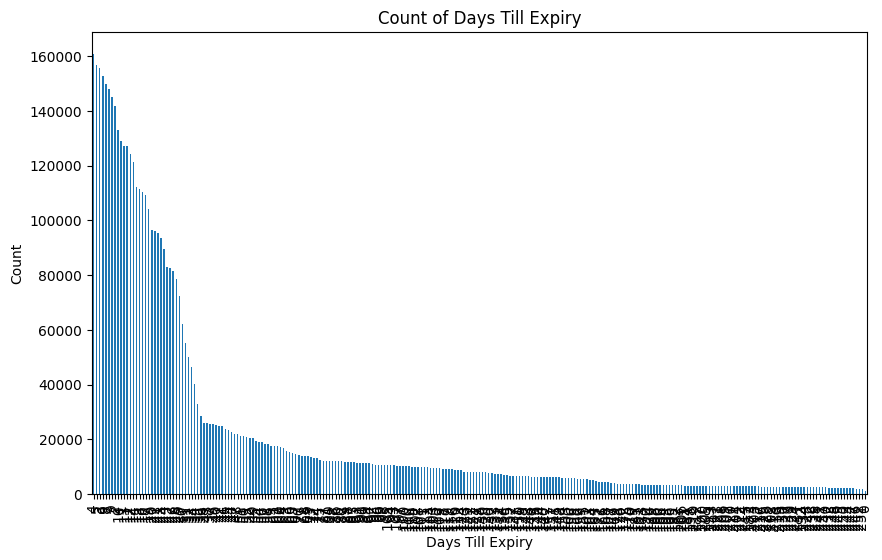

In [11]:
# Get the counts of 'days_till_exp'
df_pandas = df.to_pandas()

counts = df_pandas['trading_days_till_exp'].value_counts()

# Create the bar plot
counts.plot(kind='bar', figsize=(10, 6))
plt.title('Count of Days Till Expiry')
plt.xlabel('Days Till Expiry')
plt.ylabel('Count')
plt.show()

# Merging the stock prices with the options

In [12]:
# Reading the stock data
stock_path_parq = Path.cwd().parent / "Data/Stock_data/stock_data.parquet"
df_stock = pl.read_parquet(stock_path_parq)

# Convert Polars dataframes to pandas
df = df.to_pandas()
df_stock = df_stock.to_pandas()

# Ensure that 'date' is a datetime object in both dataframes
df['date'] = pd.to_datetime(df['date'])
df_stock['date'] = pd.to_datetime(df_stock['date'])

# Rename the 'TICKER' column in df_stock to 'ticker' to match df
df_stock = df_stock.rename(columns={'TICKER': 'ticker'})

# Merge 'RET' column from df_stock into df
merged_df = pd.merge(df, df_stock[['ticker', 'date', 'PRC', 'PRC_actual']], on=['ticker', 'date'], how='left')


In [13]:
merged_df.sort_values(by='date')



,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,ticker,Prev_day_IV,trading_days_till_exp,PRC,PRC_actual
0,2018-12-31,2019-01-04,C,1432500,68.60,71.20,7,24,0.178173,0.994820,0.000533,2.351213,-53.91097,AMZN,0.507263,3,1501.96997,75.098499
4296,2018-12-31,2019-04-18,C,1970000,34.70,37.90,8,27,0.295474,0.240481,0.001124,291.660500,-155.86840,BKNG,0.333744,75,1722.42004,1722.420040
4295,2018-12-31,2019-04-18,C,1960000,36.90,40.10,4,41,0.296274,0.251166,0.001147,298.349400,-160.15010,BKNG,0.335835,75,1722.42004,1722.420040
4294,2018-12-31,2019-04-18,C,1940000,41.80,45.00,2,20,0.298536,0.273788,0.001190,311.709800,-169.02450,BKNG,0.336623,75,1722.42004,1722.420040
4293,2018-12-31,2019-04-18,C,1920000,46.60,50.30,2,19,0.299917,0.296533,0.001231,324.096200,-176.80890,BKNG,0.334178,75,1722.42004,1722.420040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4847595,2021-12-30,2021-12-31,P,170000,0.03,0.29,20,442,0.773250,-0.051148,0.014306,0.996919,-140.79350,EXPE,0.000000,1,181.47000,181.470000
4847596,2021-12-30,2021-12-31,P,175000,0.13,0.35,341,809,0.541990,-0.097790,0.033544,1.641158,-162.14880,EXPE,0.000000,1,181.47000,181.470000
4847597,2021-12-30,2021-12-31,P,177500,0.28,0.43,28,86,0.433323,-0.161837,0.059558,2.327339,-183.97820,EXPE,0.347778,1,181.47000,181.470000
4847589,2021-12-30,2021-12-31,C,200000,0.01,0.05,3,156,0.809419,0.011476,0.003913,0.286325,-42.22303,EXPE,0.406590,1,181.47000,181.470000


## Create the forward price of the stocks

In [14]:
# Load the existing firm and market data
df_firm = merged_df  # Replace with your path
df_macro = pd.read_parquet(Path.cwd().parent / "Data/Macroeconomic_variables/merged_marcofirm.parquet")  # Replace with your path

# Load the dividend data
df_dividends = pd.read_csv(Path.cwd().parent / 'Data/Stock_data/Dividend_Data_2019_2022.csv')  # Replace with your path

# Convert the DATE column to datetime format for easy merging
df_macro['DATE'] = pd.to_datetime(df_macro['DATE'])

# Calculate the annual dividend yield by grouping by ticker and summing the dividends per year
df_dividends['Date'] = pd.to_datetime(df_dividends['Date'])
df_dividends['Year'] = df_dividends['Date'].dt.year
annual_dividends = df_dividends.groupby(['Ticker', 'Year'])['Amount'].sum().reset_index()
annual_dividends['Annual_Dividend_Yield'] = annual_dividends['Amount'] / df_firm['PRC']

# Merge the annual dividend yield back to the firm data
df_firm['Year'] = df_firm['date'].dt.year
df_firm = df_firm.rename(columns={'ticker': 'Ticker'})
df_firm = df_firm.merge(annual_dividends[['Ticker', 'Year', 'Annual_Dividend_Yield']], 
                        on=['Ticker', 'Year'], how='left')

# Fill NaN values in 'Annual_Dividend_Yield' with 0
df_firm['Annual_Dividend_Yield'] = df_firm['Annual_Dividend_Yield'].fillna(0)

# Calculate time to maturity in years
df_firm['T'] = df_firm['trading_days_till_exp'] / 252

# Interpolate the 2Y bond rates for exact dates of the firm data
df_firm['DATE'] = df_firm['date']
df_firm = df_firm.merge(df_macro[['DATE', '2Y_bond']], on='DATE', how='left')
df_firm['2Y_bond'].interpolate(method='time', inplace=True)

# Convert '2Y_bond' and 'Annual_Dividend_Yield' to float
df_firm['2Y_bond'] = df_firm['2Y_bond'].astype(float)
df_firm['Annual_Dividend_Yield'] = df_firm['Annual_Dividend_Yield'].astype(float)

# Calculate forward prices using the formula F = P * e^(r - q)T
df_firm['Forward_Price'] = df_firm['PRC'] * np.exp(((df_firm['2Y_bond']/100) - df_firm['Annual_Dividend_Yield']) * df_firm['T'])

# Save the updated dataframe with the Forward Price column
# updated_file_path = "/mnt/data/Updated_Firm_Data.csv"
# df_firm.to_csv(updated_file_path, index=False)


/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_66022/1560370389.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_firm['2Y_bond'].interpolate(method='time', inplace=True)
/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_66022/1560370389.py:32: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_firm['2Y_bond'].interpolate(method='time', inplace=True)


In [15]:
df_macro

,DATE,FF_rate,gold_price,reces_indi,10Y_RIR,1Y_bond,2Y_bond,OPEN_vix,HIGH_vix,LOW_vix,CLOSE_vix,spread_vix
0,2018-12-30,2.40,NaN,NaN,None,None,None,NaN,NaN,NaN,NaN,NaN
1,2018-12-31,2.40,449.000000,0.130000,2.66,2.5342,2.5442,31.72,31.74,28.57,28.57,3.17
2,2019-01-01,2.40,449.000000,0.130000,2.66,2.5342,2.5442,NaN,NaN,NaN,NaN,NaN
3,2019-01-02,2.40,449.354839,0.131290,2.66,2.5342,2.5442,31.46,31.46,22.82,22.82,8.64
4,2019-01-03,2.40,449.709677,0.132581,2.56,2.4762,2.4613,25.82,28.95,24.47,26.59,4.48
...,...,...,...,...,...,...,...,...,...,...,...,...
1094,2021-12-28,0.08,632.632258,-0.209032,1.49,0.4835,0.8040,15.01,15.88,14.39,14.40,1.49
1095,2021-12-29,0.08,632.874194,-0.206774,1.55,0.4878,0.8182,14.36,14.60,12.56,12.85,2.04
1096,2021-12-30,0.08,633.116129,-0.204516,1.52,0.4793,0.8076,13.69,14.41,12.98,13.86,1.43
1097,2021-12-31,0.07,633.358065,-0.202258,1.52,0.4764,0.8017,14.24,14.62,13.15,13.26,1.47


In [16]:
df = df_firm


# Function to calculate the ATM IV and add it to the DataFrame
def add_atm_iv(df):
    # Sort DataFrame to ensure correct grouping
    df = df.sort_values(by=['date', 'exdate', 'strike_price'])
    
    # Group by 'date' and 'PRC', here 'PRC' is assumed to be the relevant column for grouping
    grouped = df.groupby(['exdate', 'Forward_Price'])
    
    atm_iv_list = []
    
    # Iterate over each group
    for name, group in grouped:
        # Find the row with the strike price closest to PRC_actual
        group['strike_diff'] = abs((group['strike_price']/1000) - group['Forward_Price'])
        atm_row = group.loc[group['strike_diff'].idxmin()]
        
        # The ATM implied volatility for this group
        atm_iv = atm_row['impl_volatility']
        
        # Assign this ATM IV to all rows in the group
        group['atm_impl_volatility'] = atm_iv
        
        # Append to the list
        atm_iv_list.append(group)
    
    # Concatenate all the groups back into a single DataFrame
    result_df = pd.concat(atm_iv_list)
    
    # Drop the temporary 'strike_diff' column
    result_df = result_df.drop(columns=['strike_diff'])
    
    return result_df

# Applying the function to the DataFrame
df_with_atm_iv = add_atm_iv(df)

print(df_with_atm_iv)

              date     exdate cp_flag  strike_price  best_bid  best_offer  \
960838  2019-01-03 2019-01-04       P         70000      0.00        0.02   
960839  2019-01-03 2019-01-04       P         80000      0.00        0.02   
960840  2019-01-03 2019-01-04       P         83500      0.00        0.02   
960841  2019-01-03 2019-01-04       P         85000      0.00        0.01   
960842  2019-01-03 2019-01-04       P         86000      0.00        0.02   
...            ...        ...     ...           ...       ...         ...   
4133615 2021-11-18 2021-12-31       C       4800000      4.35        6.30   
4133616 2021-11-18 2021-12-31       C       4850000      3.90        5.75   
4133617 2021-11-18 2021-12-31       C       4900000      3.50        5.30   
4133618 2021-11-18 2021-12-31       C       4950000      3.15        4.90   
4133619 2021-11-18 2021-12-31       C       5000000      2.82        4.00   

         volume  open_interest  impl_volatility     delta  ...  \
960838   

In [17]:
df_with_atm_iv.sort_values(by='trading_days_till_exp')

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,...,trading_days_till_exp,PRC,PRC_actual,Year,Annual_Dividend_Yield,T,DATE,2Y_bond,Forward_Price,atm_impl_volatility
5474291,2021-11-11,2021-11-12,P,305000,0.02,0.04,265,2375,0.583326,-0.008861,...,0,327.73999,327.739990,2021,0.000000,0.0,2021-11-11,0.5956,327.739990,0.298534
5278535,2021-11-11,2021-11-12,C,1080000,6.95,7.20,24256,4569,0.615663,0.322372,...,0,1063.51001,354.503337,2021,0.000000,0.0,2021-11-11,0.5956,1063.510010,0.607729
5278676,2021-11-11,2021-11-12,P,1080000,22.60,23.30,8881,3214,0.584792,-0.686906,...,0,1063.51001,354.503337,2021,0.000000,0.0,2021-11-11,0.5956,1063.510010,0.607729
5278536,2021-11-11,2021-11-12,C,1085000,5.80,6.00,8294,1312,0.629432,0.277454,...,0,1063.51001,354.503337,2021,0.000000,0.0,2021-11-11,0.5956,1063.510010,0.607729
5278677,2021-11-11,2021-11-12,P,1085000,26.35,27.15,2734,1241,0.594872,-0.734543,...,0,1063.51001,354.503337,2021,0.000000,0.0,2021-11-11,0.5956,1063.510010,0.607729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595048,2019-06-19,2020-06-19,P,110000,3.70,3.80,5,1902,0.264913,-0.171281,...,252,135.69000,135.690000,2019,0.001292,1.0,2019-06-19,1.8305,138.018293,0.226263
595029,2019-06-19,2020-06-19,C,115000,25.80,26.15,25,1589,0.256125,0.781984,...,252,135.69000,135.690000,2019,0.001292,1.0,2019-06-19,1.8305,138.018293,0.226263
595049,2019-06-19,2020-06-19,P,115000,4.70,4.85,11,5077,0.256293,-0.212238,...,252,135.69000,135.690000,2019,0.001292,1.0,2019-06-19,1.8305,138.018293,0.226263
595050,2019-06-19,2020-06-19,P,120000,6.00,6.15,4,5679,0.249316,-0.260090,...,252,135.69000,135.690000,2019,0.001292,1.0,2019-06-19,1.8305,138.018293,0.226263


## Create the moneyness column

In [18]:
merged_df = df_with_atm_iv 

merged_df['moneyness'] = np.log((merged_df['strike_price']/1000) / merged_df['Forward_Price']) / \
                       (np.sqrt(merged_df['T']) * merged_df['atm_impl_volatility'])

# Optionally save the updated DataFrame to a new CSV
# df_firm.to_csv('updated_dataframe_with_moneyness.csv', index=False)

# Print the DataFrame or specific columns to verify the moneyness calculations
print(merged_df[['strike_price', 'Forward_Price', 'T', 'Prev_day_IV', 'moneyness']])

         strike_price  Forward_Price         T  Prev_day_IV  moneyness
960838          70000      92.868540  0.003968     2.853282 -13.300494
960839          80000      92.868540  0.003968     1.667636  -7.017868
960840          83500      92.868540  0.003968     1.266451  -5.003196
960841          85000      92.868540  0.003968     1.136790  -4.165492
960842          86000      92.868540  0.003968     1.018112  -3.615196
...               ...            ...       ...          ...        ...
4133615       4800000    3698.594681  0.115079     0.285033   2.867516
4133616       4850000    3698.594681  0.115079     0.000000   2.981515
4133617       4900000    3698.594681  0.115079     0.000000   3.094346
4133618       4950000    3698.594681  0.115079     0.000000   3.206030
4133619       5000000    3698.594681  0.115079     0.000000   3.316593

[5485206 rows x 5 columns]


## Create the trading_day column

In [19]:
# Sort the DataFrame by date
merged_df = merged_df.sort_values('date')

# Create a new column 'trading_day' that ranks each unique date
merged_df['trading_day'] = merged_df['date'].rank(method='dense').astype(int)

# Create a few filters for the dataframe and an overview

In [20]:
#Create moneyness filter
pl_merged = pl.from_pandas(merged_df)

pl_merged = pl_merged.filter((pl.col("moneyness") >= moneyness_min) & (pl.col("moneyness") <= moneyness_max))

pd_merged = pl_merged.to_pandas()


In [21]:
pd_merged

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,...,PRC_actual,Year,Annual_Dividend_Yield,T,DATE,2Y_bond,Forward_Price,atm_impl_volatility,moneyness,trading_day
0,2018-12-31,2019-02-01,P,100000,4.05,4.30,96,161,0.421652,-0.420134,...,101.570000,2018,0.000000,0.087302,2018-12-31,2.5442,101.795851,0.356037,-0.169197,1
1,2018-12-31,2019-03-15,P,285000,18.35,18.85,1,957,0.695918,-0.252615,...,22.186666,2018,0.000000,0.202381,2018-12-31,2.5442,334.517988,0.583113,-0.610701,1
2,2018-12-31,2019-03-15,C,290000,61.65,62.65,2,398,0.642135,0.738736,...,22.186666,2018,0.000000,0.202381,2018-12-31,2.5442,334.517988,0.583113,-0.544403,1
3,2018-12-31,2019-03-15,P,290000,19.75,20.25,33,795,0.686739,-0.269399,...,22.186666,2018,0.000000,0.202381,2018-12-31,2.5442,334.517988,0.583113,-0.544403,1
4,2018-12-31,2019-03-15,C,295000,58.30,59.30,10,171,0.637395,0.719884,...,22.186666,2018,0.000000,0.202381,2018-12-31,2.5442,334.517988,0.583113,-0.479237,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5313731,2021-12-30,2021-12-31,P,3280000,0.46,0.84,632,897,0.290004,-0.032255,...,168.644495,2021,0.000000,0.003968,2021-12-30,0.8076,3372.997985,0.229000,-1.938114,757
5313732,2021-12-30,2021-12-31,C,3280000,89.55,97.65,3,64,0.290930,0.967323,...,168.644495,2021,0.000000,0.003968,2021-12-30,0.8076,3372.997985,0.229000,-1.938114,757
5313733,2021-12-30,2021-12-31,P,3275000,0.40,0.78,471,554,0.298067,-0.028917,...,168.644495,2021,0.000000,0.003968,2021-12-30,0.8076,3372.997985,0.229000,-2.043866,757
5313734,2021-12-30,2021-12-31,P,3265000,0.34,0.68,223,645,0.316048,-0.024143,...,168.644495,2021,0.000000,0.003968,2021-12-30,0.8076,3372.997985,0.229000,-2.255857,757


In [22]:
df = pd_merged

# Define maturity ranges for tau (τ)
bins = [0, 5, 20, 60, float('inf')]  # upper bounds are exclusive except the last
labels = ['τ≤5', '5<τ≤20', '20<τ≤60', 'τ>60']
df['maturity_group'] = pd.cut(df['trading_days_till_exp'], bins=bins, labels=labels, right=True)

# Define m categories based on delta (adjust as needed)
def classify_m(delta):
    if delta < -2:
        return 'm<-2'
    elif -2 <= delta <= 2:
        return '|m|≤2'
    else:
        return 'm>2'

df['m_category'] = df['moneyness'].apply(classify_m)

# Calculate Number of Contracts (%) and Volume (%)
# Group by maturity group and m category, then calculate counts and volume sums
summary = df.groupby(['maturity_group', 'm_category']).agg(
    Number_of_contracts=pd.NamedAgg(column='date', aggfunc='count'),  # Assuming each row is a contract
    Volume=pd.NamedAgg(column='volume', aggfunc='sum')
)

# Calculate percentages
total_contracts = summary['Number_of_contracts'].sum()
total_volume = summary['Volume'].sum()
summary['Number_of_contracts (%)'] = (summary['Number_of_contracts'] / total_contracts) * 100
summary['Volume (%)'] = (summary['Volume'] / total_volume) * 100

# Pivot table with reset index for adding totals
result = summary.pivot_table(index='maturity_group', columns='m_category', 
                             values=['Number_of_contracts (%)', 'Volume (%)'], 
                             fill_value=0).swaplevel(axis=1).sort_index(axis=1)

# Add totals across all columns and rows
result.loc['Total', :] = result.sum()
result['Total'] = result.sum(axis=1)

print(result)

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_66022/3825521651.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby(['maturity_group', 'm_category']).agg(


m_category                        m<-2                                m>2  \
               Number_of_contracts (%) Volume (%) Number_of_contracts (%)   
maturity_group                                                              
τ≤5                           3.237477   4.048874                1.909429   
5<τ≤20                        5.660180   1.979014                3.086962   
20<τ≤60                       3.850436   0.813501                1.664742   
τ>60                          2.464650   0.340019                0.432878   
Total                        15.212743   7.181408                7.094011   

m_category                                  |m|≤2                  Total  
               Volume (%) Number_of_contracts (%) Volume (%)              
maturity_group                                                            
τ≤5              3.368337                7.061905  49.023311   68.649333  
5<τ≤20           1.248661               25.461671  22.810510   60.246998  
20<τ≤60 

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_66022/3825521651.py:33: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  result = summary.pivot_table(index='maturity_group', columns='m_category',


In [23]:
result

m_category                        m<-2                                m>2  \
               Number_of_contracts (%) Volume (%) Number_of_contracts (%)   
maturity_group                                                              
τ≤5                           3.237477   4.048874                1.909429   
5<τ≤20                        5.660180   1.979014                3.086962   
20<τ≤60                       3.850436   0.813501                1.664742   
τ>60                          2.464650   0.340019                0.432878   
Total                        15.212743   7.181408                7.094011   

m_category                                  |m|≤2                  Total  
               Volume (%) Number_of_contracts (%) Volume (%)              
maturity_group                                                            
τ≤5              3.368337                7.061905  49.023311   68.649333  
5<τ≤20           1.248661               25.461671  22.810510   60.246998  
20<τ≤60          0.418498               24.521674  11.135811   42.404661  
τ>60             0.076143               20.647996   4.737321   28.699008  
Total            5.111639               77.693246  87.706953  200.000000

In [24]:
pd_merged

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,...,Annual_Dividend_Yield,T,DATE,2Y_bond,Forward_Price,atm_impl_volatility,moneyness,trading_day,maturity_group,m_category
0,2018-12-31,2019-02-01,P,100000,4.05,4.30,96,161,0.421652,-0.420134,...,0.000000,0.087302,2018-12-31,2.5442,101.795851,0.356037,-0.169197,1,20<τ≤60,|m|≤2
1,2018-12-31,2019-03-15,P,285000,18.35,18.85,1,957,0.695918,-0.252615,...,0.000000,0.202381,2018-12-31,2.5442,334.517988,0.583113,-0.610701,1,20<τ≤60,|m|≤2
2,2018-12-31,2019-03-15,C,290000,61.65,62.65,2,398,0.642135,0.738736,...,0.000000,0.202381,2018-12-31,2.5442,334.517988,0.583113,-0.544403,1,20<τ≤60,|m|≤2
3,2018-12-31,2019-03-15,P,290000,19.75,20.25,33,795,0.686739,-0.269399,...,0.000000,0.202381,2018-12-31,2.5442,334.517988,0.583113,-0.544403,1,20<τ≤60,|m|≤2
4,2018-12-31,2019-03-15,C,295000,58.30,59.30,10,171,0.637395,0.719884,...,0.000000,0.202381,2018-12-31,2.5442,334.517988,0.583113,-0.479237,1,20<τ≤60,|m|≤2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5313731,2021-12-30,2021-12-31,P,3280000,0.46,0.84,632,897,0.290004,-0.032255,...,0.000000,0.003968,2021-12-30,0.8076,3372.997985,0.229000,-1.938114,757,τ≤5,|m|≤2
5313732,2021-12-30,2021-12-31,C,3280000,89.55,97.65,3,64,0.290930,0.967323,...,0.000000,0.003968,2021-12-30,0.8076,3372.997985,0.229000,-1.938114,757,τ≤5,|m|≤2
5313733,2021-12-30,2021-12-31,P,3275000,0.40,0.78,471,554,0.298067,-0.028917,...,0.000000,0.003968,2021-12-30,0.8076,3372.997985,0.229000,-2.043866,757,τ≤5,m<-2
5313734,2021-12-30,2021-12-31,P,3265000,0.34,0.68,223,645,0.316048,-0.024143,...,0.000000,0.003968,2021-12-30,0.8076,3372.997985,0.229000,-2.255857,757,τ≤5,m<-2


In [25]:
import pandas as pd
import plotly.graph_objects as go

# Create a copy of pd_merged
pd_merged_copy = pd_merged.copy()

# Convert the string to a pandas Timestamp
date = pd.Timestamp('2019-01-11')

# Use the copy for the filtering
pd_merged_2 = pd_merged_copy[(pd_merged_copy["trading_days_till_exp"] <= 10) & (pd_merged_copy["m_category"] == "|m|≤2") & (pd_merged_copy['cp_flag'] == 'P')]
# Filter the DataFrame for the 'NVDA' ticker and the specific date
df_nvda = pd_merged_2[(pd_merged_2['Ticker'] == 'AMZN') & (pd_merged_2['date'] == date)]

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=df_nvda['moneyness'],
    y=df_nvda['trading_days_till_exp'],
    z=df_nvda['impl_volatility'],
    mode='markers',
    marker=dict(
        size=3,
        color=df_nvda['impl_volatility'],  # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

# Set labels
fig.update_layout(scene = dict(
                    xaxis_title='Moneyness',
                    yaxis_title='Trading Days till Expiry',
                    zaxis_title='Implied Volatility'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

In [26]:
pd_merged

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,...,Annual_Dividend_Yield,T,DATE,2Y_bond,Forward_Price,atm_impl_volatility,moneyness,trading_day,maturity_group,m_category
0,2018-12-31,2019-02-01,P,100000,4.05,4.30,96,161,0.421652,-0.420134,...,0.000000,0.087302,2018-12-31,2.5442,101.795851,0.356037,-0.169197,1,20<τ≤60,|m|≤2
1,2018-12-31,2019-03-15,P,285000,18.35,18.85,1,957,0.695918,-0.252615,...,0.000000,0.202381,2018-12-31,2.5442,334.517988,0.583113,-0.610701,1,20<τ≤60,|m|≤2
2,2018-12-31,2019-03-15,C,290000,61.65,62.65,2,398,0.642135,0.738736,...,0.000000,0.202381,2018-12-31,2.5442,334.517988,0.583113,-0.544403,1,20<τ≤60,|m|≤2
3,2018-12-31,2019-03-15,P,290000,19.75,20.25,33,795,0.686739,-0.269399,...,0.000000,0.202381,2018-12-31,2.5442,334.517988,0.583113,-0.544403,1,20<τ≤60,|m|≤2
4,2018-12-31,2019-03-15,C,295000,58.30,59.30,10,171,0.637395,0.719884,...,0.000000,0.202381,2018-12-31,2.5442,334.517988,0.583113,-0.479237,1,20<τ≤60,|m|≤2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5313731,2021-12-30,2021-12-31,P,3280000,0.46,0.84,632,897,0.290004,-0.032255,...,0.000000,0.003968,2021-12-30,0.8076,3372.997985,0.229000,-1.938114,757,τ≤5,|m|≤2
5313732,2021-12-30,2021-12-31,C,3280000,89.55,97.65,3,64,0.290930,0.967323,...,0.000000,0.003968,2021-12-30,0.8076,3372.997985,0.229000,-1.938114,757,τ≤5,|m|≤2
5313733,2021-12-30,2021-12-31,P,3275000,0.40,0.78,471,554,0.298067,-0.028917,...,0.000000,0.003968,2021-12-30,0.8076,3372.997985,0.229000,-2.043866,757,τ≤5,m<-2
5313734,2021-12-30,2021-12-31,P,3265000,0.34,0.68,223,645,0.316048,-0.024143,...,0.000000,0.003968,2021-12-30,0.8076,3372.997985,0.229000,-2.255857,757,τ≤5,m<-2


In [27]:
import pandas as pd
import numpy as np
from scipy.interpolate import griddata
import plotly.graph_objects as go

# Convert the string to a pandas Timestamp
date = pd.Timestamp('2019-01-11')

# Create a copy of pd_merged
pd_merged_copy = pd_merged.copy()

# Use the copy for the filtering
pd_merged_1 = pd_merged_copy[(pd_merged_copy["trading_days_till_exp"] <= 10) & (pd_merged_copy["m_category"] == "|m|≤2") & (pd_merged_copy['cp_flag'] == 'C')]
# Filter the DataFrame for the 'NVDA' ticker and the specific date
df__nvda = pd_merged_1[(pd_merged_1['Ticker'] == 'AMZN') & (pd_merged_1['date'] == date)]

# Create a grid of x and y values
x = np.linspace(df__nvda['moneyness'].min(), df__nvda['moneyness'].max(), len(df__nvda['moneyness'].unique()))
y = np.linspace(df__nvda['trading_days_till_exp'].min(), df__nvda['trading_days_till_exp'].max(), len(df__nvda['trading_days_till_exp'].unique()))
x_grid, y_grid = np.meshgrid(x, y)

# Interpolate z values
z_grid = griddata((df__nvda['moneyness'], df__nvda['trading_days_till_exp']), df__nvda['impl_volatility'], (x_grid, y_grid), method='cubic')

# Create a 3D surface plot
fig = go.Figure(data=[go.Surface(x=x_grid, y=y_grid, z=z_grid, colorscale='Viridis')])

# Set labels
fig.update_layout(scene = dict(
                    xaxis_title='Moneyness',
                    yaxis_title='Trading days till Expiry',
                    zaxis_title='Implied Volatility'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

In [28]:
pd_merged_1

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,...,Annual_Dividend_Yield,T,DATE,2Y_bond,Forward_Price,atm_impl_volatility,moneyness,trading_day,maturity_group,m_category
78,2018-12-31,2019-01-11,C,410000,0.12,0.23,54,134,0.546336,0.015978,...,0.000000,0.031746,2018-12-31,2.5442,333.068895,0.598373,1.949149,1,5<τ≤20,|m|≤2
79,2018-12-31,2019-01-11,C,405000,0.15,0.28,9,233,0.534438,0.019582,...,0.000000,0.031746,2018-12-31,2.5442,333.068895,0.598373,1.834061,1,5<τ≤20,|m|≤2
80,2018-12-31,2019-01-11,C,402500,0.19,0.33,4,111,0.535254,0.023164,...,0.000000,0.031746,2018-12-31,2.5442,333.068895,0.598373,1.775983,1,5<τ≤20,|m|≤2
81,2018-12-31,2019-01-11,C,400000,0.24,0.37,56,357,0.533798,0.026752,...,0.000000,0.031746,2018-12-31,2.5442,333.068895,0.598373,1.717543,1,5<τ≤20,|m|≤2
82,2018-12-31,2019-01-11,C,397500,0.32,0.43,6,29,0.536663,0.031958,...,0.000000,0.031746,2018-12-31,2.5442,333.068895,0.598373,1.658737,1,5<τ≤20,|m|≤2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5313726,2021-12-30,2021-12-31,C,3295000,75.70,82.95,7,31,0.291616,0.938136,...,0.000000,0.003968,2021-12-30,0.8076,3372.997985,0.229000,-1.621819,757,τ≤5,|m|≤2
5313728,2021-12-30,2021-12-31,C,3290000,80.60,87.65,13,47,0.296350,0.946610,...,0.000000,0.003968,2021-12-30,0.8076,3372.997985,0.229000,-1.727091,757,τ≤5,|m|≤2
5313730,2021-12-30,2021-12-31,C,3285000,84.60,92.65,3,9,0.279628,0.965051,...,0.000000,0.003968,2021-12-30,0.8076,3372.997985,0.229000,-1.832522,757,τ≤5,|m|≤2
5313732,2021-12-30,2021-12-31,C,3280000,89.55,97.65,3,64,0.290930,0.967323,...,0.000000,0.003968,2021-12-30,0.8076,3372.997985,0.229000,-1.938114,757,τ≤5,|m|≤2


## Plots of the data

In [29]:
df = pd_merged

# Define maturity ranges for tau (τ)
bins = [0, 5, 20, 60, float('inf')]  # upper bounds are exclusive except the last
labels = ['τ≤5', '5<τ≤20', '20<τ≤60', 'τ>60']
df['maturity_group'] = pd.cut(df['trading_days_till_exp'], bins=bins, labels=labels, right=True)

# Define m categories based on delta (adjust as needed)
def classify_m(delta):
    if delta < -2:
        return 'm<-2'
    elif -2 <= delta <= -0.5:
        return '-2≤m<-0.5'
    elif -0.5 < delta <= 0:
        return '-0.5<m≤0'
    elif 0 < delta <= 0.5:
        return '0<m≤0.5'
    elif 0.5 < delta <= 2:
        return '0.5<m≤2'
    else:
        return 'm>2'

df['m_category'] = df['moneyness'].apply(classify_m)

# Calculate Number of Contracts (%) and Volume (%)
# Group by maturity group and m category, then calculate counts and volume sums
summary = df.groupby(['maturity_group', 'm_category']).agg(
    Number_of_contracts=pd.NamedAgg(column='date', aggfunc='count'),  # Assuming each row is a contract
    Volume=pd.NamedAgg(column='volume', aggfunc='sum')
)

# Calculate percentages
total_contracts = summary['Number_of_contracts'].sum()
total_volume = summary['Volume'].sum()
summary['Number_of_contracts (%)'] = (summary['Number_of_contracts'] / total_contracts) * 100
summary['Volume (%)'] = (summary['Volume'] / total_volume) * 100

# Pivot table with reset index for adding totals
result = summary.pivot_table(index='maturity_group', columns='m_category', 
                             values=['Number_of_contracts (%)', 'Volume (%)'], 
                             fill_value=0).swaplevel(axis=1).sort_index(axis=1)

# Add totals across all columns and rows
result.loc['Total', :] = result.sum()
result['Total'] = result.sum(axis=1)


/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_66022/116368190.py:27: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_66022/116368190.py:39: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



In [30]:
result

m_category                    -0.5<m≤0                          -2≤m<-0.5  \
               Number_of_contracts (%) Volume (%) Number_of_contracts (%)   
maturity_group                                                              
τ≤5                           1.075533  10.361783                2.546269   
5<τ≤20                        4.800163   4.777542                8.559872   
20<τ≤60                       5.283006   2.459909                7.739602   
τ>60                          4.762318   1.079591                6.393468   
Total                        15.921021  18.678825               25.239210   

m_category                                0.5<m≤2             \
               Volume (%) Number_of_contracts (%) Volume (%)   
maturity_group                                                 
τ≤5             10.945160                2.368861  15.444960   
5<τ≤20           5.097810                7.439192   7.094356   
20<τ≤60          2.451852                6.501490   3.245789   
τ>60             1.066341                5.089395   1.268136   
Total           19.561163               21.398937  27.053240   

m_category                     0<m≤0.5                               m<-2  \
               Number_of_contracts (%) Volume (%) Number_of_contracts (%)   
maturity_group                                                              
τ≤5                           1.071243  12.271408                3.237477   
5<τ≤20                        4.662445   5.840801                5.660180   
20<τ≤60                       4.997576   2.978262                3.850436   
τ>60                          4.402816   1.323253                2.464650   
Total                        15.134079  22.413725               15.212743   

m_category                                    m>2                  Total  
               Volume (%) Number_of_contracts (%) Volume (%)              
maturity_group                                                            
τ≤5              4.048874                1.909429   3.368337   68.649333  
5<τ≤20           1.979014                3.086962   1.248661   60.246998  
20<τ≤60          0.813501                1.664742   0.418498   42.404661  
τ>60             0.340019                0.432878   0.076143   28.699008  
Total            7.181408                7.094011   5.111639  200.000000

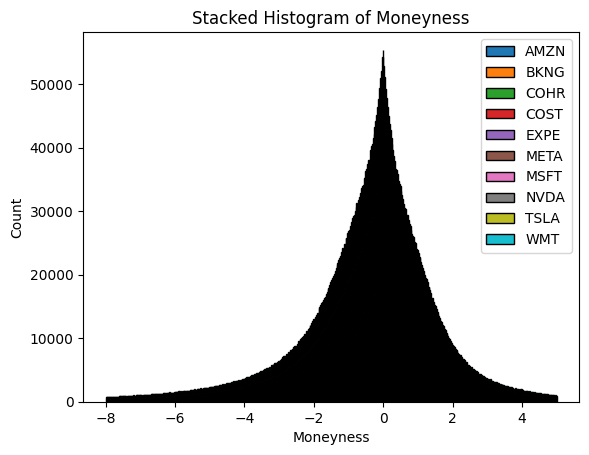

In [31]:
# Group the DataFrame by the 'ticker' column
grouped = pd_merged.groupby('Ticker')

# Create a list of data for each group
data = [group['moneyness'] for name, group in grouped]

# Create a list of labels for each group
labels = [name for name, group in grouped]

# Create a stacked histogram
plt.hist(data, bins=500, stacked=True, edgecolor='black', label=labels)

# Set the title and labels
plt.title('Stacked Histogram of Moneyness')
plt.xlabel('Moneyness')
plt.ylabel('Count')

# Set the x-limits
# plt.xlim(0, 2)

# Add a legend
plt.legend()

# Show the plot
plt.show()

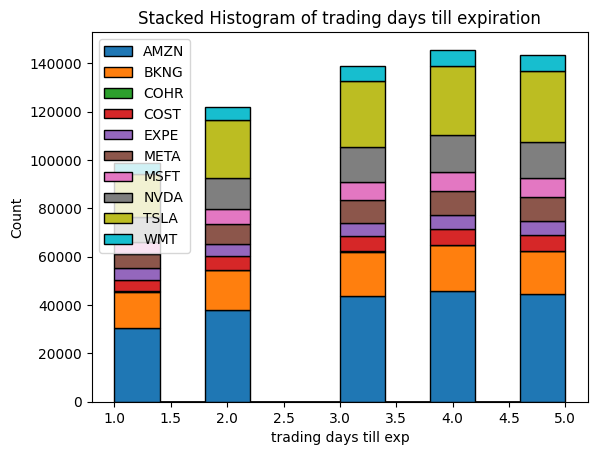

In [32]:
# Create the wished filted
# pd_maturity = pd_merged[(pd_merged["trading_days_till_exp"] <= 6) & (pd_merged["m_category"] == "|m| ≤ 2")]
pd_maturity = pd_merged[(pd_merged["trading_days_till_exp"] <= 5) & (pd_merged["m_category"] != "m < 2") & (pd_merged["m_category"] != "m > 2")]

# Group the DataFrame by the 'ticker' column
grouped = pd_maturity.groupby('Ticker')

# Create a list of data for each group
data = [group['trading_days_till_exp'] for name, group in grouped]

# Create a list of labels for each group
labels = [name for name, group in grouped]

# Create a stacked histogram
plt.hist(data, stacked=True, edgecolor='black', label=labels, width=0.4)

# Set the title and labels
plt.title('Stacked Histogram of trading days till expiration')
plt.xlabel('trading days till exp')
plt.ylabel('Count')

# Set the x-limits
# plt.xlim(0, 2)

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [33]:
# Filter the DataFrame
pd_maturity = pd_merged[(pd_merged["trading_days_till_exp"] <= 5) & (pd_merged["m_category"] == "|m| ≤ 2")]

# Group the DataFrame by the 'ticker' and 'strike_price' columns and count the number of occurrences
grouped = pd_maturity.groupby(['Ticker', 'strike_price']).size().reset_index(name='counts')

# Calculate the average moneyness for each 'Ticker' and 'strike_price'
average_moneyness = pd_maturity.groupby(['Ticker', 'strike_price'])['moneyness'].mean().reset_index(name='average_moneyness')

# Calculate the total volume for each 'Ticker' and 'strike_price'
total_volume = pd_maturity.groupby(['Ticker', 'strike_price'])['volume'].sum().reset_index(name='total_volume')

# Merge the average moneyness and total volume with the grouped DataFrame
grouped = pd.merge(grouped, average_moneyness, on=['Ticker', 'strike_price'])
grouped = pd.merge(grouped, total_volume, on=['Ticker', 'strike_price'])

# Sort the DataFrame by 'total_volume' in descending order and then group by 'Ticker' to get the top 3 strike prices for each stock
top_strike_prices = grouped.sort_values('total_volume', ascending=False).groupby('Ticker').head(3)

# Print the top 3 strike prices for each stock along with the counts, average moneyness, and total volume
for ticker, group in top_strike_prices.groupby('Ticker'):
    print(f"Top 3 strike prices for {ticker}:")
    print(group[['strike_price', 'counts', 'average_moneyness', 'total_volume']])
    print("\n")

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_66022/357412170.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



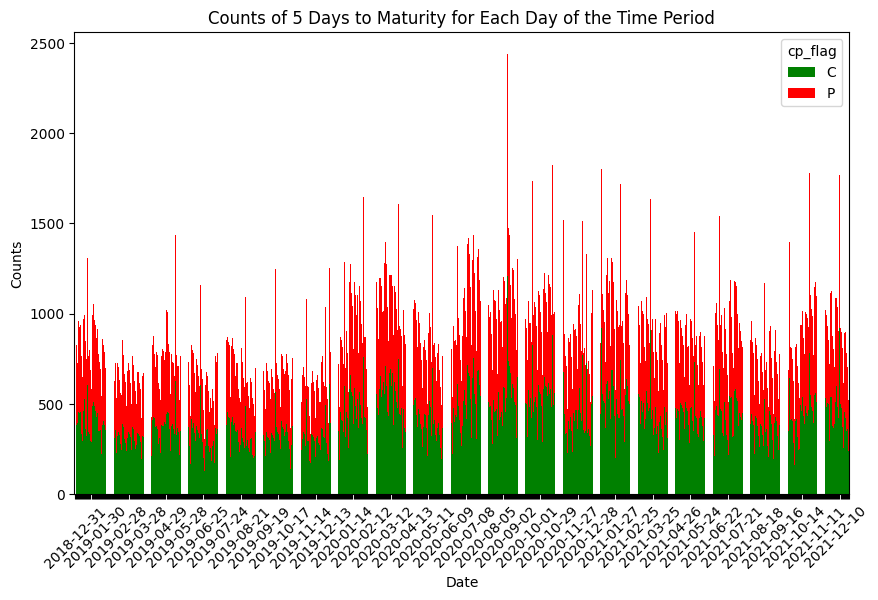

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Filter the DataFrame to only include rows where the trading days till expiration is 6
pd_maturity_6_days = pd_merged[pd_merged["trading_days_till_exp"] <= 5]

# Convert the 'date' column to just date without time
pd_maturity_6_days['date'] = pd.to_datetime(pd_maturity_6_days['date']).dt.date

# Group by the date and 'cp_flag' and count the number of occurrences
counts_by_date = pd_maturity_6_days.groupby(['date', 'cp_flag']).size().unstack(fill_value=0)

# Create a bar plot of the counts by date
ax = counts_by_date.plot(kind='bar', stacked=True, color=['green', 'red'], figsize=(10, 6), width=.8)

plt.title('Counts of 5 Days to Maturity for Each Day of the Time Period')
plt.xlabel('Date')
plt.ylabel('Counts')

# Rotate the x labels and only show every nth label
n = 20  # Show every nth label
for index, label in enumerate(ax.xaxis.get_ticklabels()):
    if index % n != 0:
        label.set_visible(False)
    label.set_rotation(45)

plt.show()

In [35]:
#Look at one moneyness specific
filtered_df_c = pd_merged[(pd_merged['trading_days_till_exp'] <= 5) & (pd_merged['moneyness'] >= 0) & (pd_merged['moneyness'] <= 0.5) & (pd_merged['volume'] > 0) & (pd_merged['cp_flag'] == 'C')]

selected_columns = ['Ticker', 'date', 'exdate', 'cp_flag', 'delta', 'impl_volatility', 'Prev_day_IV', 'atm_impl_volatility', 'trading_days_till_exp', 'moneyness']
filtered_df_c = filtered_df_c[selected_columns]
filtered_df_c = filtered_df_c.rename(columns={'trading_days_till_exp': 'tau'})

filtered_df_c.sort_values(by=['Ticker', 'date', 'exdate', 'tau'], inplace=True)

filtered_df_c


,Ticker,date,exdate,cp_flag,delta,impl_volatility,Prev_day_IV,atm_impl_volatility,tau,moneyness
3659,AMZN,2018-12-31,2019-01-04,C,0.324856,0.399080,0.458004,0.388391,3,0.467706
3661,AMZN,2018-12-31,2019-01-04,C,0.338549,0.397904,0.334143,0.388391,3,0.429179
3663,AMZN,2018-12-31,2019-01-04,C,0.352346,0.396169,0.458851,0.388391,3,0.390589
3665,AMZN,2018-12-31,2019-01-04,C,0.367052,0.396001,0.374368,0.388391,3,0.351936
3667,AMZN,2018-12-31,2019-01-04,C,0.381927,0.395650,0.458406,0.388391,3,0.313219
...,...,...,...,...,...,...,...,...,...,...
5311046,WMT,2021-12-27,2021-12-31,C,0.323870,0.178364,0.165577,0.171067,4,0.402138
5311067,WMT,2021-12-27,2021-12-31,C,0.467034,0.171067,0.169905,0.171067,4,0.074232
5312071,WMT,2021-12-28,2021-12-31,C,0.298029,0.173454,0.188117,0.167877,3,0.460233
5312083,WMT,2021-12-28,2021-12-31,C,0.463931,0.167877,0.201037,0.167877,3,0.079783


In [36]:
import pandas as pd
import plotly.graph_objects as go

# Create a copy of pd_merged
filtered_df_c_copy = filtered_df_c.copy()

# Convert the string to a pandas Timestamp
date = pd.Timestamp('2019-01-11')

# Use the copy for the filtering
pd_merged_3 = filtered_df_c_copy[(filtered_df_c_copy["tau"] <= 10) & (filtered_df_c_copy['cp_flag'] == 'C')]
# Filter the DataFrame for the 'NVDA' ticker and the specific date
df_nvda = pd_merged_3[(pd_merged_3['Ticker'] == 'AMZN')]

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=df_nvda['moneyness'],
    y=df_nvda['tau'],
    z=df_nvda['impl_volatility'],
    mode='markers',
    marker=dict(
        size=3,
        color=df_nvda['impl_volatility'],  # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

# Set labels
fig.update_layout(scene = dict(
                    xaxis_title='Moneyness',
                    yaxis_title='Trading Days till Expiry',
                    zaxis_title='Implied Volatility'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

In [37]:
filtered_df_c['exdate'] = pd.to_datetime(filtered_df_c['exdate'])
train_data = filtered_df_c[filtered_df_c['exdate'].dt.year <= 2020]
test_data = filtered_df_c[filtered_df_c['exdate'].dt.year == 2021]

In [38]:
train_data

,Ticker,date,exdate,cp_flag,delta,impl_volatility,Prev_day_IV,atm_impl_volatility,tau,moneyness
3659,AMZN,2018-12-31,2019-01-04,C,0.324856,0.399080,0.458004,0.388391,3,0.467706
3661,AMZN,2018-12-31,2019-01-04,C,0.338549,0.397904,0.334143,0.388391,3,0.429179
3663,AMZN,2018-12-31,2019-01-04,C,0.352346,0.396169,0.458851,0.388391,3,0.390589
3665,AMZN,2018-12-31,2019-01-04,C,0.367052,0.396001,0.374368,0.388391,3,0.351936
3667,AMZN,2018-12-31,2019-01-04,C,0.381927,0.395650,0.458406,0.388391,3,0.313219
...,...,...,...,...,...,...,...,...,...,...
3577254,WMT,2020-12-23,2020-12-31,C,0.332719,0.186541,0.000000,0.192365,5,0.455807
3582867,WMT,2020-12-24,2020-12-31,C,0.438924,0.152029,0.000000,0.152029,4,0.181579
3592356,WMT,2020-12-28,2020-12-31,C,0.385852,0.197152,0.211791,0.196374,3,0.249983
3595522,WMT,2020-12-29,2020-12-31,C,0.373338,0.197559,0.251654,0.202319,2,0.268463


In [39]:
from sklearn.metrics import mean_absolute_error

# Group by 'Ticker', 'moneyness' and 'tau', then calculate the mean implied volatility
forecast = train_data.groupby(['Ticker', 'moneyness', 'tau'])['impl_volatility'].mean().reset_index()

# Pivot the table to have 'moneyness' and 'tau' as indices and 'Ticker' as columns
forecast_pivot = forecast.pivot_table(index=['moneyness', 'tau'], columns='Ticker', values='impl_volatility')

# Merge the test data with the forecast
merged = pd.merge(test_data, forecast, on=['Ticker', 'moneyness', 'tau'], how='left', suffixes=('_actual', '_forecast'))

# Calculate the MAE for each ticker, excluding rows with NaN values
mae = merged.dropna(subset=['impl_volatility_actual', 'impl_volatility_forecast']).groupby('Ticker').apply(lambda x: mean_absolute_error(x['impl_volatility_actual'], x['impl_volatility_forecast']))

# Print the ticker with the lowest MAE

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_66022/2415703505.py:13: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [40]:
pd_merged

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,...,Annual_Dividend_Yield,T,DATE,2Y_bond,Forward_Price,atm_impl_volatility,moneyness,trading_day,maturity_group,m_category
0,2018-12-31,2019-02-01,P,100000,4.05,4.30,96,161,0.421652,-0.420134,...,0.000000,0.087302,2018-12-31,2.5442,101.795851,0.356037,-0.169197,1,20<τ≤60,-0.5<m≤0
1,2018-12-31,2019-03-15,P,285000,18.35,18.85,1,957,0.695918,-0.252615,...,0.000000,0.202381,2018-12-31,2.5442,334.517988,0.583113,-0.610701,1,20<τ≤60,-2≤m<-0.5
2,2018-12-31,2019-03-15,C,290000,61.65,62.65,2,398,0.642135,0.738736,...,0.000000,0.202381,2018-12-31,2.5442,334.517988,0.583113,-0.544403,1,20<τ≤60,-2≤m<-0.5
3,2018-12-31,2019-03-15,P,290000,19.75,20.25,33,795,0.686739,-0.269399,...,0.000000,0.202381,2018-12-31,2.5442,334.517988,0.583113,-0.544403,1,20<τ≤60,-2≤m<-0.5
4,2018-12-31,2019-03-15,C,295000,58.30,59.30,10,171,0.637395,0.719884,...,0.000000,0.202381,2018-12-31,2.5442,334.517988,0.583113,-0.479237,1,20<τ≤60,-0.5<m≤0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5313731,2021-12-30,2021-12-31,P,3280000,0.46,0.84,632,897,0.290004,-0.032255,...,0.000000,0.003968,2021-12-30,0.8076,3372.997985,0.229000,-1.938114,757,τ≤5,-2≤m<-0.5
5313732,2021-12-30,2021-12-31,C,3280000,89.55,97.65,3,64,0.290930,0.967323,...,0.000000,0.003968,2021-12-30,0.8076,3372.997985,0.229000,-1.938114,757,τ≤5,-2≤m<-0.5
5313733,2021-12-30,2021-12-31,P,3275000,0.40,0.78,471,554,0.298067,-0.028917,...,0.000000,0.003968,2021-12-30,0.8076,3372.997985,0.229000,-2.043866,757,τ≤5,m<-2
5313734,2021-12-30,2021-12-31,P,3265000,0.34,0.68,223,645,0.316048,-0.024143,...,0.000000,0.003968,2021-12-30,0.8076,3372.997985,0.229000,-2.255857,757,τ≤5,m<-2


In [41]:
# Saving file 
option_data_path_parq = Path.cwd().parent / "Data/all_options_data.parquet"

save_parquet = True
if save_parquet or not os.path.exists(option_data_path_parq):
    pd_merged.to_parquet(option_data_path_parq)

## Group the moneyness on every trading day

In [2]:
import polars as pl
import os
from pathlib import Path
import pandas as pd
import hvplot.polars
import datetime
import matplotlib.pyplot as plt
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay



sso_data = Path.cwd().parent / "Data/Option_data/SSO_complete.csv"
parquet_file = (Path.cwd().parent / "Data/Option_data/SSO_complete")

data_path = Path.cwd().parent / "Data"

#Restrictions
timeperiod = [datetime.datetime(2018, 12, 30), datetime.datetime(2021, 12, 31)]
volume_r = 0
open_interest_r = 0
delta_r = 0
vega_r = 0
theta_r = 0
gamma_r = 0
midprice_r = 0.3
bid_price_r = 0.0
days_till_exp_r1 = 7
days_till_exp_r2 = 252
moneyness_min = -8
moneyness_max = 5



In [3]:
#Read the file
option_data_path_parq = Path.cwd().parent / "Data/all_options_data.parquet"

df = pd.read_parquet(option_data_path_parq)

print(df.columns)

df['spread_option'] = df['best_offer'] - df['best_bid']

df

Index(['date', 'exdate', 'cp_flag', 'strike_price', 'best_bid', 'best_offer',
       'volume', 'open_interest', 'impl_volatility', 'delta', 'gamma', 'vega',
       'theta', 'Ticker', 'Prev_day_IV', 'trading_days_till_exp', 'PRC',
       'PRC_actual', 'Year', 'Annual_Dividend_Yield', 'T', 'DATE', '2Y_bond',
       'Forward_Price', 'atm_impl_volatility', 'moneyness', 'trading_day',
       'maturity_group', 'm_category'],
      dtype='object')


,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,...,T,DATE,2Y_bond,Forward_Price,atm_impl_volatility,moneyness,trading_day,maturity_group,m_category,spread_option
0,2018-12-31,2019-02-01,P,100000,4.05,4.30,96,161,0.421652,-0.420134,...,0.087302,2018-12-31,2.5442,101.795851,0.356037,-0.169197,1,20<τ≤60,-0.5<m≤0,0.25
1,2018-12-31,2019-03-15,P,285000,18.35,18.85,1,957,0.695918,-0.252615,...,0.202381,2018-12-31,2.5442,334.517988,0.583113,-0.610701,1,20<τ≤60,-2≤m<-0.5,0.50
2,2018-12-31,2019-03-15,C,290000,61.65,62.65,2,398,0.642135,0.738736,...,0.202381,2018-12-31,2.5442,334.517988,0.583113,-0.544403,1,20<τ≤60,-2≤m<-0.5,1.00
3,2018-12-31,2019-03-15,P,290000,19.75,20.25,33,795,0.686739,-0.269399,...,0.202381,2018-12-31,2.5442,334.517988,0.583113,-0.544403,1,20<τ≤60,-2≤m<-0.5,0.50
4,2018-12-31,2019-03-15,C,295000,58.30,59.30,10,171,0.637395,0.719884,...,0.202381,2018-12-31,2.5442,334.517988,0.583113,-0.479237,1,20<τ≤60,-0.5<m≤0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5313731,2021-12-30,2021-12-31,P,3280000,0.46,0.84,632,897,0.290004,-0.032255,...,0.003968,2021-12-30,0.8076,3372.997985,0.229000,-1.938114,757,τ≤5,-2≤m<-0.5,0.38
5313732,2021-12-30,2021-12-31,C,3280000,89.55,97.65,3,64,0.290930,0.967323,...,0.003968,2021-12-30,0.8076,3372.997985,0.229000,-1.938114,757,τ≤5,-2≤m<-0.5,8.10
5313733,2021-12-30,2021-12-31,P,3275000,0.40,0.78,471,554,0.298067,-0.028917,...,0.003968,2021-12-30,0.8076,3372.997985,0.229000,-2.043866,757,τ≤5,m<-2,0.38
5313734,2021-12-30,2021-12-31,P,3265000,0.34,0.68,223,645,0.316048,-0.024143,...,0.003968,2021-12-30,0.8076,3372.997985,0.229000,-2.255857,757,τ≤5,m<-2,0.34


In [4]:
test_df = df[['m_category', 'Ticker', 'maturity_group', 'cp_flag', 'date', 'impl_volatility', 'Prev_day_IV', 'volume', 'open_interest', 'trading_days_till_exp', 'spread_option']]

In [5]:
test_df

,m_category,Ticker,maturity_group,cp_flag,date,impl_volatility,Prev_day_IV,volume,open_interest,trading_days_till_exp,spread_option
0,-0.5<m≤0,MSFT,20<τ≤60,P,2018-12-31,0.421652,0.352599,96,161,22,0.25
1,-2≤m<-0.5,TSLA,20<τ≤60,P,2018-12-31,0.695918,0.648589,1,957,51,0.50
2,-2≤m<-0.5,TSLA,20<τ≤60,C,2018-12-31,0.642135,0.748824,2,398,51,1.00
3,-2≤m<-0.5,TSLA,20<τ≤60,P,2018-12-31,0.686739,0.642135,33,795,51,0.50
4,-0.5<m≤0,TSLA,20<τ≤60,C,2018-12-31,0.637395,0.738378,10,171,51,1.00
...,...,...,...,...,...,...,...,...,...,...,...
5313731,-2≤m<-0.5,AMZN,τ≤5,P,2021-12-30,0.290004,0.290930,632,897,1,0.38
5313732,-2≤m<-0.5,AMZN,τ≤5,C,2021-12-30,0.290930,0.295391,3,64,1,8.10
5313733,m<-2,AMZN,τ≤5,P,2021-12-30,0.298067,0.299928,471,554,1,0.38
5313734,m<-2,AMZN,τ≤5,P,2021-12-30,0.316048,0.000000,223,645,1,0.34


In [6]:
print(test_df.columns)

Index(['m_category', 'Ticker', 'maturity_group', 'cp_flag', 'date',
       'impl_volatility', 'Prev_day_IV', 'volume', 'open_interest',
       'trading_days_till_exp', 'spread_option'],
      dtype='object')


In [7]:
test1_df = test_df.copy()
grouped_df = test1_df.groupby(['m_category','maturity_group', 'Ticker', 'date', 'cp_flag']).mean().replace(np.nan, 0)

testindex = grouped_df.reset_index()


/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_66102/73361320.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = test1_df.groupby(['m_category','maturity_group', 'Ticker', 'date', 'cp_flag']).mean().replace(np.nan, 0)


In [8]:
testindex

,m_category,maturity_group,Ticker,date,cp_flag,impl_volatility,Prev_day_IV,volume,open_interest,trading_days_till_exp,spread_option
0,-0.5<m≤0,τ≤5,AMZN,2018-12-31,C,0.379154,0.414265,600.083333,278.666667,3.0,0.970833
1,-0.5<m≤0,τ≤5,AMZN,2018-12-31,P,0.528633,0.379154,804.750000,131.500000,3.0,0.708333
2,-0.5<m≤0,τ≤5,AMZN,2019-01-02,C,0.445693,0.420886,1016.416667,437.750000,2.0,2.179167
3,-0.5<m≤0,τ≤5,AMZN,2019-01-02,P,0.485497,0.445693,740.916667,157.250000,2.0,0.650000
4,-0.5<m≤0,τ≤5,AMZN,2019-01-03,C,0.580082,0.389773,292.909091,359.272727,1.0,1.054545
...,...,...,...,...,...,...,...,...,...,...,...
363355,m>2,τ>60,WMT,2021-12-28,P,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
363356,m>2,τ>60,WMT,2021-12-29,C,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
363357,m>2,τ>60,WMT,2021-12-29,P,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
363358,m>2,τ>60,WMT,2021-12-30,C,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


## Merging the dataframe with the firm characteristics & Macroeconomic variables & Stock Data

In [9]:
#Aplying filter to test the data
final_grouped_df = testindex

filter_version = final_grouped_df[(final_grouped_df['cp_flag'] == 'C') & (final_grouped_df['m_category'] == '-0.5<m≤0') & (final_grouped_df['maturity_group'] == 'τ≤5') & (final_grouped_df['Ticker'] == 'AMZN')]

filter_version

,m_category,maturity_group,Ticker,date,cp_flag,impl_volatility,Prev_day_IV,volume,open_interest,trading_days_till_exp,spread_option
0,-0.5<m≤0,τ≤5,AMZN,2018-12-31,C,0.379154,0.414265,600.083333,278.666667,3.0,0.970833
2,-0.5<m≤0,τ≤5,AMZN,2019-01-02,C,0.445693,0.420886,1016.416667,437.750000,2.0,2.179167
4,-0.5<m≤0,τ≤5,AMZN,2019-01-03,C,0.580082,0.389773,292.909091,359.272727,1.0,1.054545
6,-0.5<m≤0,τ≤5,AMZN,2019-01-04,C,0.379247,0.000000,392.937500,152.875000,5.0,1.096875
8,-0.5<m≤0,τ≤5,AMZN,2019-01-07,C,0.469937,0.375359,942.315789,245.315789,4.0,1.321053
...,...,...,...,...,...,...,...,...,...,...,...
1504,-0.5<m≤0,τ≤5,AMZN,2021-12-23,C,0.246134,0.000000,518.916667,613.583333,5.0,4.395833
1506,-0.5<m≤0,τ≤5,AMZN,2021-12-27,C,0.299242,0.290612,201.000000,94.500000,4.0,3.666667
1508,-0.5<m≤0,τ≤5,AMZN,2021-12-28,C,0.257500,0.298016,1530.888889,872.666667,3.0,2.527778
1510,-0.5<m≤0,τ≤5,AMZN,2021-12-29,C,0.239400,0.299284,557.571429,213.571429,2.0,2.635714


In [11]:
# Check for NaN values column-wise
nan_columns = testindex.isnull().sum()
print("Number of NaN values in each column:")
print(nan_columns)

# Add columns with NaN values to a list
nan_columns_list = nan_columns[nan_columns > 0].index.tolist()
print("Columns with NaN values:")
print(nan_columns_list)

Number of NaN values in each column:
m_category               0
maturity_group           0
Ticker                   0
date                     0
cp_flag                  0
impl_volatility          0
Prev_day_IV              0
volume                   0
open_interest            0
trading_days_till_exp    0
spread_option            0
dtype: int64
Columns with NaN values:
[]


In [13]:
#Merge with macroeconomic variables
df_macro = pd.read_parquet(Path.cwd().parent / "Data/Macroeconomic_variables/merged_marcofirm.parquet")

df_macro['date'] = pd.to_datetime(df_macro['DATE'])

# Remove two collumns
df_macro = df_macro.drop(columns=['DATE'])

total_merge_df = pd.merge(testindex, df_macro[df_macro.columns], on=['date'], how='left')

# # Ensure that objects are floats
total_merge_df['10Y_RIR'] = total_merge_df['10Y_RIR'].astype(float)
total_merge_df['1Y_bond'] = total_merge_df['1Y_bond'].astype(float)
total_merge_df['2Y_bond'] = total_merge_df['2Y_bond'].astype(float)

# Shift with the option en macro data

In [14]:
# Create a copy of the DataFrame
groupedtest_df_copy = total_merge_df.copy()

# Set the index to the specified columns
groupedtest_df_copy.set_index(['cp_flag', 'm_category','maturity_group', 'Ticker', 'date'], inplace=True)

# Create the lag variable for each row, except for 'impl_volatility' and 'prev_day_IV'
cols_to_shift = [col for col in groupedtest_df_copy.columns if col not in ['impl_volatility', 'Prev_day_IV', 'trading_days_till_exp']]
groupedtest_df_copy[cols_to_shift] = groupedtest_df_copy.groupby(level=0)[cols_to_shift].shift(1)

# Reset the index
groupedtest_df_copy.reset_index(inplace=True)

In [15]:
groupedtest_df_copy

,cp_flag,m_category,maturity_group,Ticker,date,impl_volatility,Prev_day_IV,volume,open_interest,trading_days_till_exp,...,gold_price,reces_indi,10Y_RIR,1Y_bond,2Y_bond,OPEN_vix,HIGH_vix,LOW_vix,CLOSE_vix,spread_vix
0,C,-0.5<m≤0,τ≤5,AMZN,2018-12-31,0.379154,0.414265,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P,-0.5<m≤0,τ≤5,AMZN,2018-12-31,0.528633,0.379154,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C,-0.5<m≤0,τ≤5,AMZN,2019-01-02,0.445693,0.420886,600.083333,278.666667,2.0,...,449.000000,0.130000,2.66,2.5342,2.5442,31.72,31.74,28.57,28.57,3.17
3,P,-0.5<m≤0,τ≤5,AMZN,2019-01-02,0.485497,0.445693,804.750000,131.500000,2.0,...,449.000000,0.130000,2.66,2.5342,2.5442,31.72,31.74,28.57,28.57,3.17
4,C,-0.5<m≤0,τ≤5,AMZN,2019-01-03,0.580082,0.389773,1016.416667,437.750000,1.0,...,449.354839,0.131290,2.66,2.5342,2.5442,31.46,31.46,22.82,22.82,8.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363355,P,m>2,τ>60,WMT,2021-12-28,0.000000,0.000000,0.000000,0.000000,0.0,...,632.390323,-0.211290,1.48,0.4807,0.8002,16.14,16.43,14.20,14.48,2.23
363356,C,m>2,τ>60,WMT,2021-12-29,0.000000,0.000000,0.000000,0.000000,0.0,...,632.632258,-0.209032,1.49,0.4835,0.8040,15.01,15.88,14.39,14.40,1.49
363357,P,m>2,τ>60,WMT,2021-12-29,0.000000,0.000000,0.000000,0.000000,0.0,...,632.632258,-0.209032,1.49,0.4835,0.8040,15.01,15.88,14.39,14.40,1.49
363358,C,m>2,τ>60,WMT,2021-12-30,0.000000,0.000000,0.000000,0.000000,0.0,...,632.874194,-0.206774,1.55,0.4878,0.8182,14.36,14.60,12.56,12.85,2.04


# Merge with the stock data

In [16]:
#Merge with stock vairables
# Reading the stock data
stock_path_parq = Path.cwd().parent / "Data/Stock_data/stock_data.parquet"
df_stock = pd.read_parquet(stock_path_parq)

# Ensure that 'date' is a datetime object in both dataframes
df['date'] = pd.to_datetime(df['date'])
df_stock['date'] = pd.to_datetime(df_stock['date'])

# # Rename the 'TICKER' column in df_stock to 'ticker' to match df
df_stock = df_stock.rename(columns={'TICKER': 'Ticker'})

total_merge_df = total_merge_df.rename(columns={'volume': 'volume_option'})
total_merge_df = total_merge_df.rename(columns={'open_interest': 'open_interest_option'})
# Remove two collumns
df_stock = df_stock.drop(columns=['PERMNO'])

# Merge 'RET' column from df_stock into df
# merged_df = pd.merge(total_merge_df, df_stock[['Ticker', 'date', 'vol_stock', 'daily_return_indicator_stock',
#        '5_day_rolling_return_stock', 'hi-lo_stock', 'spread_stock']], on=['Ticker', 'date'], how='left')

df_stock.columns

Index(['date', 'Ticker', 'BIDLO', 'ASKHI', 'PRC', 'vol_stock', 'RET', 'BID',
       'ASK', 'RETX', 'PRC_actual', 'cumulative_return',
       'daily_return_indicator_stock', '5_day_rolling_return_stock',
       'hi-lo_stock', 'spread_stock'],
      dtype='object')

In [17]:
# Create a copy of the DataFrame
df_stock_copy = df_stock.copy()

# Set the index to the date column
df_stock_copy.set_index('date', inplace=True)

# Group by ticker and create the lag variable for each row
df_stock_copy = df_stock_copy.groupby('Ticker').apply(lambda x: x.shift(1), include_groups=False)

# Reset the index
df_stock_copy.reset_index(inplace=True)

# total_merge_df = df_stock_copy.filter(
#     pl.col("date").is_between(timeperiod[0], timeperiod[1]),
# )

In [18]:
df_stock_copy

,Ticker,date,BIDLO,ASKHI,PRC,vol_stock,RET,BID,ASK,RETX,PRC_actual,cumulative_return,daily_return_indicator_stock,5_day_rolling_return_stock,hi-lo_stock,spread_stock
0,AMZN,2018-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AMZN,2019-01-02,1487.00000,1520.76001,1501.96997,6954507.0,0.016204,1503.39001,1504.41003,0.016204,75.098499,0.267619,1.0,0.090400,33.76001,1.02002
2,AMZN,2019-01-03,1460.93005,1553.35999,1539.13000,7981083.0,0.024741,1538.94995,1539.13000,0.024741,76.956500,0.299395,1.0,0.145221,92.42994,0.18005
3,AMZN,2019-01-04,1497.10999,1538.00000,1500.28003,6975572.0,-0.025242,1499.58997,1500.35999,-0.025242,75.014001,0.266173,-1.0,0.019975,40.89001,0.77002
4,AMZN,2019-01-07,1518.31006,1594.00000,1575.39001,9182420.0,0.050064,1575.39001,1575.85999,0.050064,78.769501,0.330400,1.0,0.077824,75.68994,0.46998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7575,WMT,2021-12-27,138.85001,140.16000,139.49001,5864216.0,-0.002217,139.49001,139.50000,-0.002217,46.496670,0.525605,-1.0,-0.026860,1.30999,0.00999
7576,WMT,2021-12-28,139.57001,140.87000,140.75999,5351125.0,0.009105,140.77000,140.78999,0.009105,46.919997,0.539481,1.0,0.014487,1.29999,0.01999
7577,WMT,2021-12-29,140.60001,142.97000,142.78000,5263016.0,0.014351,142.78999,142.81000,0.014351,47.593333,0.561551,1.0,0.025719,2.36999,0.02001
7578,WMT,2021-12-30,142.32001,143.53000,142.71001,4348420.0,-0.000490,142.71001,142.72000,-0.000490,47.570003,0.560787,-1.0,0.022133,1.20999,0.00999


In [19]:
merged_df = pd.merge(groupedtest_df_copy, df_stock_copy[['Ticker', 'date', 'vol_stock', 'daily_return_indicator_stock',
       '5_day_rolling_return_stock', 'hi-lo_stock', 'spread_stock']], on=['Ticker', 'date'], how='left')

In [20]:
merged_df

,cp_flag,m_category,maturity_group,Ticker,date,impl_volatility,Prev_day_IV,volume,open_interest,trading_days_till_exp,...,OPEN_vix,HIGH_vix,LOW_vix,CLOSE_vix,spread_vix,vol_stock,daily_return_indicator_stock,5_day_rolling_return_stock,hi-lo_stock,spread_stock
0,C,-0.5<m≤0,τ≤5,AMZN,2018-12-31,0.379154,0.414265,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P,-0.5<m≤0,τ≤5,AMZN,2018-12-31,0.528633,0.379154,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C,-0.5<m≤0,τ≤5,AMZN,2019-01-02,0.445693,0.420886,600.083333,278.666667,2.0,...,31.72,31.74,28.57,28.57,3.17,6954507.0,1.0,0.090400,33.76001,1.02002
3,P,-0.5<m≤0,τ≤5,AMZN,2019-01-02,0.485497,0.445693,804.750000,131.500000,2.0,...,31.72,31.74,28.57,28.57,3.17,6954507.0,1.0,0.090400,33.76001,1.02002
4,C,-0.5<m≤0,τ≤5,AMZN,2019-01-03,0.580082,0.389773,1016.416667,437.750000,1.0,...,31.46,31.46,22.82,22.82,8.64,7981083.0,1.0,0.145221,92.42994,0.18005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363355,P,m>2,τ>60,WMT,2021-12-28,0.000000,0.000000,0.000000,0.000000,0.0,...,16.14,16.43,14.20,14.48,2.23,5351125.0,1.0,0.014487,1.29999,0.01999
363356,C,m>2,τ>60,WMT,2021-12-29,0.000000,0.000000,0.000000,0.000000,0.0,...,15.01,15.88,14.39,14.40,1.49,5263016.0,1.0,0.025719,2.36999,0.02001
363357,P,m>2,τ>60,WMT,2021-12-29,0.000000,0.000000,0.000000,0.000000,0.0,...,15.01,15.88,14.39,14.40,1.49,5263016.0,1.0,0.025719,2.36999,0.02001
363358,C,m>2,τ>60,WMT,2021-12-30,0.000000,0.000000,0.000000,0.000000,0.0,...,14.36,14.60,12.56,12.85,2.04,4348420.0,-1.0,0.022133,1.20999,0.00999


In [22]:
#Merge with option characteristics
firm_path_parq = Path.cwd().parent / "Data/Firm_variables/daily_firm_data_median_tick.parquet"
df_firm = pd.read_parquet(firm_path_parq)

df_firm['date'] = pd.to_datetime(df_firm['DATE'])

# Remove two collumns
df_firm = df_firm.drop(columns=['DATE', 'permno'])

testnew_df = pd.merge(merged_df, df_firm[df_firm.columns], on=['Ticker','date'], how='left')

In [23]:
testnew_df

,cp_flag,m_category,maturity_group,Ticker,date,impl_volatility,Prev_day_IV,volume,open_interest,trading_days_till_exp,...,stdcf,ms,baspread,ill,maxret,retvol,std_dolvol,std_turn,zerotrade,sic2
0,C,-0.5<m≤0,τ≤5,AMZN,2018-12-31,0.379154,0.414265,NaN,NaN,3.0,...,0.109152,7.0,0.037502,2.038802e-12,0.068590,0.031503,0.292637,3.440804,7.311294e-09,59.0
1,P,-0.5<m≤0,τ≤5,AMZN,2018-12-31,0.528633,0.379154,NaN,NaN,3.0,...,0.109152,7.0,0.037502,2.038802e-12,0.068590,0.031503,0.292637,3.440804,7.311294e-09,59.0
2,C,-0.5<m≤0,τ≤5,AMZN,2019-01-02,0.445693,0.420886,600.083333,278.666667,2.0,...,0.108803,7.0,0.038171,2.053226e-12,0.070258,0.031948,0.286277,3.475288,7.308848e-09,59.0
3,P,-0.5<m≤0,τ≤5,AMZN,2019-01-02,0.485497,0.445693,804.750000,131.500000,2.0,...,0.108803,7.0,0.038171,2.053226e-12,0.070258,0.031948,0.286277,3.475288,7.308848e-09,59.0
4,C,-0.5<m≤0,τ≤5,AMZN,2019-01-03,0.580082,0.389773,1016.416667,437.750000,1.0,...,0.108628,7.0,0.038505,2.060438e-12,0.071093,0.032170,0.283097,3.492530,7.307624e-09,59.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363355,P,m>2,τ>60,WMT,2021-12-28,0.000000,0.000000,0.000000,0.000000,0.0,...,0.037889,4.0,0.014628,6.590021e-12,0.017217,0.009666,0.457712,1.817912,3.353414e-08,53.0
363356,C,m>2,τ>60,WMT,2021-12-29,0.000000,0.000000,0.000000,0.000000,0.0,...,0.037889,4.0,0.014667,6.519701e-12,0.017073,0.009684,0.464769,1.858888,3.322837e-08,53.0
363357,P,m>2,τ>60,WMT,2021-12-29,0.000000,0.000000,0.000000,0.000000,0.0,...,0.037889,4.0,0.014667,6.519701e-12,0.017073,0.009684,0.464769,1.858888,3.322837e-08,53.0
363358,C,m>2,τ>60,WMT,2021-12-30,0.000000,0.000000,0.000000,0.000000,0.0,...,0.037889,4.0,0.014706,6.449380e-12,0.016929,0.009703,0.471827,1.899864,3.292261e-08,53.0


In [ ]:
# #Merge with stock vairables
# # Reading the stock data
# stock_path_parq = Path.cwd().parent / "Data/Stock_data/stock_data.parquet"
# df_stock = pd.read_parquet(stock_path_parq)

# # Ensure that 'date' is a datetime object in both dataframes
# df['date'] = pd.to_datetime(df['date'])
# df_stock['date'] = pd.to_datetime(df_stock['date'])

# # # Rename the 'TICKER' column in df_stock to 'ticker' to match df
# df_stock = df_stock.rename(columns={'TICKER': 'Ticker'})

# total_merge_df = total_merge_df.rename(columns={'volume': 'volume_option'})
# total_merge_df = total_merge_df.rename(columns={'open_interest': 'open_interest_option'})
# # Remove two collumns
# df_stock = df_stock.drop(columns=['PERMNO'])

# # Merge 'RET' column from df_stock into df
# merged_df = pd.merge(total_merge_df, df_stock[['Ticker', 'date', 'vol_stock', 'daily_return_indicator_stock',
#        '5_day_rolling_return_stock', 'hi-lo_stock', 'spread_stock']], on=['Ticker', 'date'], how='left')

# df_stock.columns

Index(['date', 'Ticker', 'BIDLO', 'ASKHI', 'PRC', 'vol_stock', 'RET', 'BID',
       'ASK', 'RETX', 'PRC_actual', 'cumulative_return',
       'daily_return_indicator_stock', '5_day_rolling_return_stock',
       'hi-lo_stock', 'spread_stock'],
      dtype='object')

# We now make it lag variables by applying a shift

In [ ]:
# # Create a copy of the DataFrame
# df_stock_copy = df_stock.copy()

# # Set the index to the date column
# df_stock_copy.set_index('date', inplace=True)

# # Group by ticker and create the lag variable for each row
# df_stock_copy = df_stock_copy.groupby('Ticker').apply(lambda x: x.shift(1), include_groups=False)

# # Reset the index
# df_stock_copy.reset_index(inplace=True)

# # total_merge_df = df_stock_copy.filter(
# #     pl.col("date").is_between(timeperiod[0], timeperiod[1]),
# # )

In [36]:
total_merge_df = testnew_df[(testnew_df['date'] >= '2019-01-01') & (testnew_df['date'] <= timeperiod[1])]

In [37]:
total_merge_df

,cp_flag,m_category,maturity_group,Ticker,date,impl_volatility,Prev_day_IV,volume,open_interest,trading_days_till_exp,...,stdcf,ms,baspread,ill,maxret,retvol,std_dolvol,std_turn,zerotrade,sic2
2,C,-0.5<m≤0,τ≤5,AMZN,2019-01-02,0.445693,0.420886,600.083333,278.666667,2.0,...,0.108803,7.0,0.038171,2.053226e-12,0.070258,0.031948,0.286277,3.475288,7.308848e-09,59.0
3,P,-0.5<m≤0,τ≤5,AMZN,2019-01-02,0.485497,0.445693,804.750000,131.500000,2.0,...,0.108803,7.0,0.038171,2.053226e-12,0.070258,0.031948,0.286277,3.475288,7.308848e-09,59.0
4,C,-0.5<m≤0,τ≤5,AMZN,2019-01-03,0.580082,0.389773,1016.416667,437.750000,1.0,...,0.108628,7.0,0.038505,2.060438e-12,0.071093,0.032170,0.283097,3.492530,7.307624e-09,59.0
5,P,-0.5<m≤0,τ≤5,AMZN,2019-01-03,0.520038,0.580082,740.916667,157.250000,1.0,...,0.108628,7.0,0.038505,2.060438e-12,0.071093,0.032170,0.283097,3.492530,7.307624e-09,59.0
6,C,-0.5<m≤0,τ≤5,AMZN,2019-01-04,0.379247,0.000000,292.909091,359.272727,5.0,...,0.108453,7.0,0.038840,2.067650e-12,0.071927,0.032392,0.279916,3.509772,7.306401e-09,59.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363355,P,m>2,τ>60,WMT,2021-12-28,0.000000,0.000000,0.000000,0.000000,0.0,...,0.037889,4.0,0.014628,6.590021e-12,0.017217,0.009666,0.457712,1.817912,3.353414e-08,53.0
363356,C,m>2,τ>60,WMT,2021-12-29,0.000000,0.000000,0.000000,0.000000,0.0,...,0.037889,4.0,0.014667,6.519701e-12,0.017073,0.009684,0.464769,1.858888,3.322837e-08,53.0
363357,P,m>2,τ>60,WMT,2021-12-29,0.000000,0.000000,0.000000,0.000000,0.0,...,0.037889,4.0,0.014667,6.519701e-12,0.017073,0.009684,0.464769,1.858888,3.322837e-08,53.0
363358,C,m>2,τ>60,WMT,2021-12-30,0.000000,0.000000,0.000000,0.000000,0.0,...,0.037889,4.0,0.014706,6.449380e-12,0.016929,0.009703,0.471827,1.899864,3.292261e-08,53.0


In [38]:
# Check for NaN values column-wise
nan_columns = total_merge_df.isnull().sum()
print("Number of NaN values in each column:")
print(nan_columns)

# Add columns with NaN values to a list
nan_columns_list = nan_columns[nan_columns > 0].index.tolist()
print("Columns with NaN values:")
print(nan_columns_list)

Number of NaN values in each column:
cp_flag           0
m_category        0
maturity_group    0
Ticker            0
date              0
                 ..
retvol            0
std_dolvol        0
std_turn          0
zerotrade         0
sic2              0
Length: 122, dtype: int64
Columns with NaN values:
[]


In [39]:
grouped_df = total_merge_df.groupby(['cp_flag', 'm_category','maturity_group', 'Ticker', 'date']).mean().replace(np.nan, 0)

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_66102/1082379453.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = total_merge_df.groupby(['cp_flag', 'm_category','maturity_group', 'Ticker', 'date']).mean().replace(np.nan, 0)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Version

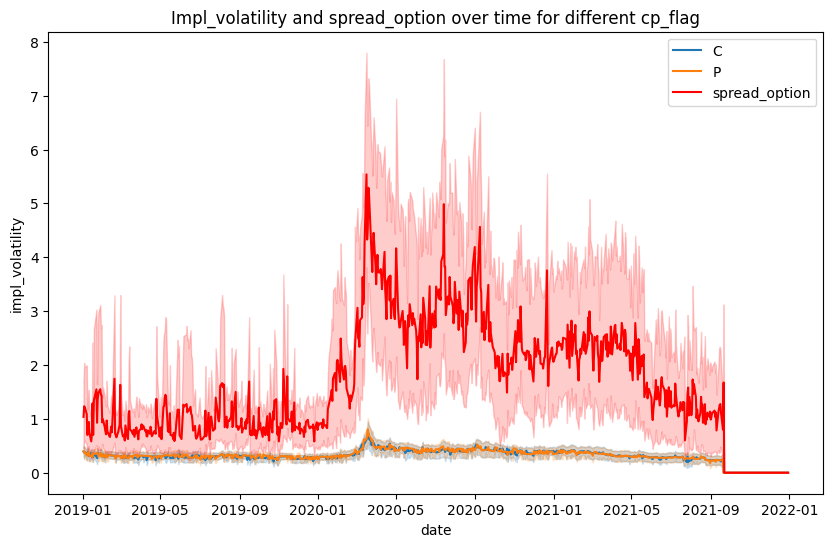

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the DataFrame
mask = ((grouped_df.index.get_level_values('m_category') == "-0.5<m≤0") & 
        (grouped_df.index.get_level_values('maturity_group') == 'τ>60'))
filtered_df = grouped_df.loc[mask]

# Create a plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='impl_volatility', hue='cp_flag', data=filtered_df)
sns.lineplot(x='date', y='spread_option', data=filtered_df, color='red', label='spread_option')
plt.title('Impl_volatility and spread_option over time for different cp_flag')
plt.show()

In [41]:
from collections import Counter

# Count the occurrences of each column name
column_counts = Counter(total_merge_df.columns)

# Get column names that occur more than once
duplicate_columns = [column for column, count in column_counts.items() if count > 1]

print(duplicate_columns)

[]


In [42]:
# Saving file 
data_set = Path.cwd().parent / "Data/total_dataset.parquet"

save_parquet = True
if save_parquet or not os.path.exists(data_set):
    total_merge_df.to_parquet(data_set)

In [43]:
total_merge_df

,cp_flag,m_category,maturity_group,Ticker,date,impl_volatility,Prev_day_IV,volume,open_interest,trading_days_till_exp,...,stdcf,ms,baspread,ill,maxret,retvol,std_dolvol,std_turn,zerotrade,sic2
2,C,-0.5<m≤0,τ≤5,AMZN,2019-01-02,0.445693,0.420886,600.083333,278.666667,2.0,...,0.108803,7.0,0.038171,2.053226e-12,0.070258,0.031948,0.286277,3.475288,7.308848e-09,59.0
3,P,-0.5<m≤0,τ≤5,AMZN,2019-01-02,0.485497,0.445693,804.750000,131.500000,2.0,...,0.108803,7.0,0.038171,2.053226e-12,0.070258,0.031948,0.286277,3.475288,7.308848e-09,59.0
4,C,-0.5<m≤0,τ≤5,AMZN,2019-01-03,0.580082,0.389773,1016.416667,437.750000,1.0,...,0.108628,7.0,0.038505,2.060438e-12,0.071093,0.032170,0.283097,3.492530,7.307624e-09,59.0
5,P,-0.5<m≤0,τ≤5,AMZN,2019-01-03,0.520038,0.580082,740.916667,157.250000,1.0,...,0.108628,7.0,0.038505,2.060438e-12,0.071093,0.032170,0.283097,3.492530,7.307624e-09,59.0
6,C,-0.5<m≤0,τ≤5,AMZN,2019-01-04,0.379247,0.000000,292.909091,359.272727,5.0,...,0.108453,7.0,0.038840,2.067650e-12,0.071927,0.032392,0.279916,3.509772,7.306401e-09,59.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363355,P,m>2,τ>60,WMT,2021-12-28,0.000000,0.000000,0.000000,0.000000,0.0,...,0.037889,4.0,0.014628,6.590021e-12,0.017217,0.009666,0.457712,1.817912,3.353414e-08,53.0
363356,C,m>2,τ>60,WMT,2021-12-29,0.000000,0.000000,0.000000,0.000000,0.0,...,0.037889,4.0,0.014667,6.519701e-12,0.017073,0.009684,0.464769,1.858888,3.322837e-08,53.0
363357,P,m>2,τ>60,WMT,2021-12-29,0.000000,0.000000,0.000000,0.000000,0.0,...,0.037889,4.0,0.014667,6.519701e-12,0.017073,0.009684,0.464769,1.858888,3.322837e-08,53.0
363358,C,m>2,τ>60,WMT,2021-12-30,0.000000,0.000000,0.000000,0.000000,0.0,...,0.037889,4.0,0.014706,6.449380e-12,0.016929,0.009703,0.471827,1.899864,3.292261e-08,53.0


In [35]:
# Check for NaN values column-wise
nan_columns = testnew_df.isnull().sum()
print("Number of NaN values in each column:")
print(nan_columns)

# Add columns with NaN values to a list
nan_columns_list = nan_columns[nan_columns > 0].index.tolist()
print("Columns with NaN values:")
print(nan_columns_list)

Number of NaN values in each column:
cp_flag           0
m_category        0
maturity_group    0
Ticker            0
date              0
                 ..
retvol            0
std_dolvol        0
std_turn          0
zerotrade         0
sic2              0
Length: 122, dtype: int64
Columns with NaN values:
['volume', 'open_interest', 'spread_option', 'FF_rate', 'gold_price', 'reces_indi', '10Y_RIR', '1Y_bond', '2Y_bond', 'OPEN_vix', 'HIGH_vix', 'LOW_vix', 'CLOSE_vix', 'spread_vix', 'vol_stock', 'daily_return_indicator_stock', '5_day_rolling_return_stock', 'hi-lo_stock', 'spread_stock']
